CSE477 Lab 5 — Clustering YouTube Comments (K-Means & DBSCAN)
Purpose. This lab applies two unsupervised clustering methods—K-Means and DBSCAN—to my cleaned YouTube comment dataset to discover discussion themes without using labels. The goal is not only to run the algorithms but to interpret what the clusters mean for the video’s audience and content.

Dataset. I use cleaned_comments.csv from Lab 2 (***cleaned_comments.csv***). The file contains preprocessed comment text (e.g., lower-casing, stopword removal, tokenization). I will confirm the shape with df.shape and preview a few rows to verify the expected columns (e.g., cleaned_tokens or cleaned_text).

Feature representation (TF-IDF). Comments are converted to numerical vectors using TF-IDF with unigrams and bigrams and a cap on max features. This balances capturing key phrases (e.g., product names, creator names, common reactions) with keeping the feature space manageable.

Clustering methods.

K-Means: I’ll choose k using the elbow method plus quality metrics (Silhouette, Calinski–Harabasz, Davies–Bouldin) to reduce ambiguity when the “elbow” is unclear. I’ll then interpret top terms per cluster and show representative comments.

DBSCAN: I’ll scale the sparse TF-IDF correctly and tune eps (0.3–1.2) with min_samples=5. DBSCAN can find arbitrarily shaped clusters and mark noise (outliers), which is useful for off-topic or spam comments.

Visualization & outputs. I’ll visualize clusters in 2D (SVD/UMAP), plot top terms for each K-Means cluster, and export a labeled CSV with both K-Means and DBSCAN labels for further analysis.

In [1]:
import pandas as pd

# Load the dataset from your drive
df = pd.read_csv('/content/drive/MyDrive/CSE477/cleaned_comments.csv')

# Print shape and preview
print(f"My dataset contains {df.shape[0]} comments and {df.shape[1]} columns.")
df.head()


My dataset contains 200 comments and 4 columns.


,username,timestamp_text,comment_text,cleaned_tokens
0,@afzalhossen8454,Unknown,Subhan allah,"['subhan', 'allah']"
1,@AnimalPrimeHub,Unknown,15:05 My heart absolutely broke for that young...,"['heart', 'absolutely', 'broke', 'young', 'mot..."
2,@PreemKaSagar,Unknown,Hm ghaar maan thay blaak bicho nay kata hmin t...,"['ghaar', 'maan', 'thay', 'blaak', 'bicho', 'n..."
3,@Hasnainraza-fm7jp,Unknown,The two truths 🎉sound like sleep and good luck...,"['two', 'truth', 'sound', 'like', 'sleep', 'go..."
4,@Nimazz_z,Unknown,😊❤,[]


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Check the correct column containing cleaned text
if 'cleaned_tokens' in df.columns:
    corpus = df['cleaned_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x)).tolist()
elif 'cleaned_text' in df.columns:
    corpus = df['cleaned_text'].astype(str).tolist()
else:
    raise Exception("No usable text column found. Please check your dataset.")

vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(corpus)

print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (200, 801)


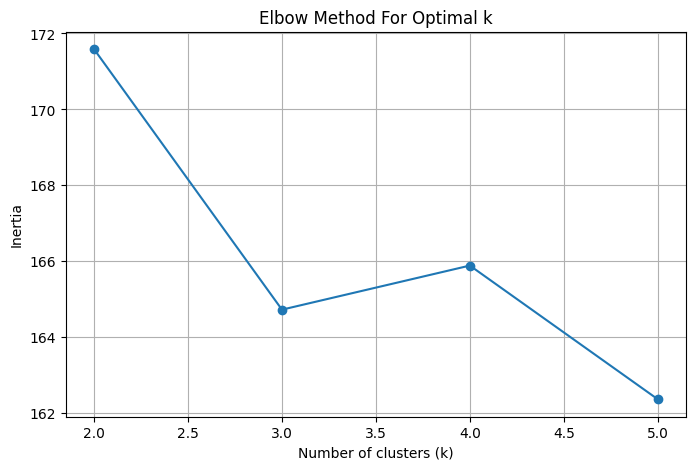

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 6)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=2)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [10]:
optimal_k = 4  # Example, change after elbow analysis

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_label'] = kmeans.fit_predict(X)

terms = vectorizer.get_feature_names_out()
for i in range(optimal_k):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]
    top_terms = [terms[idx] for idx in top_indices]
    print(f"Cluster {i}: {', '.join(top_terms)}")


Cluster 0: beautiful, picture, honestly, speaking, every, nature, soothes, video, god, thing
Cluster 1: wow, incredible, good, amazing, video, fortune, forever, forest, forced, footage
Cluster 2: untouched, human, earth, beauty, nature, hidden, secret, area, stunning, planet
Cluster 3: video, nice, nature, like, love, good, animal, allah, moment, really


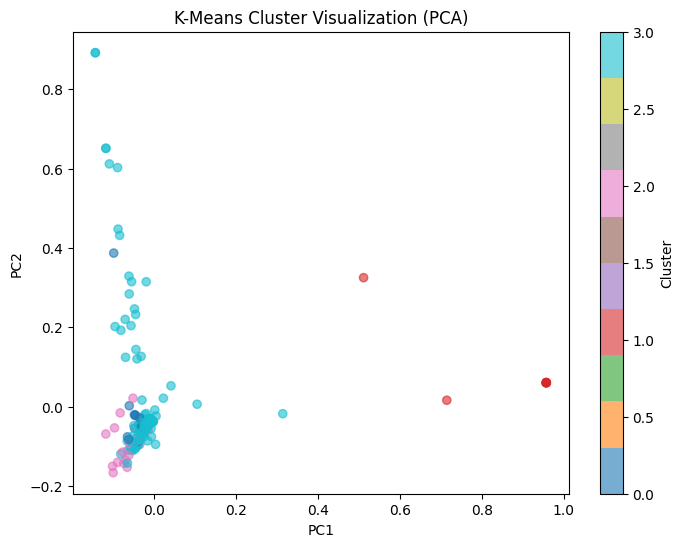

In [11]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X.toarray())

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df['kmeans_label'], cmap='tab10', alpha=0.6)
plt.title('K-Means Cluster Visualization (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler(with_mean=False).fit_transform(X)


In [13]:
from sklearn.cluster import DBSCAN
import pandas as pd

results = []
for eps in [0.3, 0.5, 0.7]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    results.append({'eps': eps, 'min_samples': 5, 'clusters': n_clusters, 'noise_points': n_noise})
    print(f"eps={eps}: clusters={n_clusters}, noise_points={n_noise}")

pd.DataFrame(results)


eps=0.3: clusters=2, noise_points=173
eps=0.5: clusters=2, noise_points=173
eps=0.7: clusters=2, noise_points=173


,eps,min_samples,clusters,noise_points
0,0.3,5,2,173
1,0.5,5,2,173
2,0.7,5,2,173


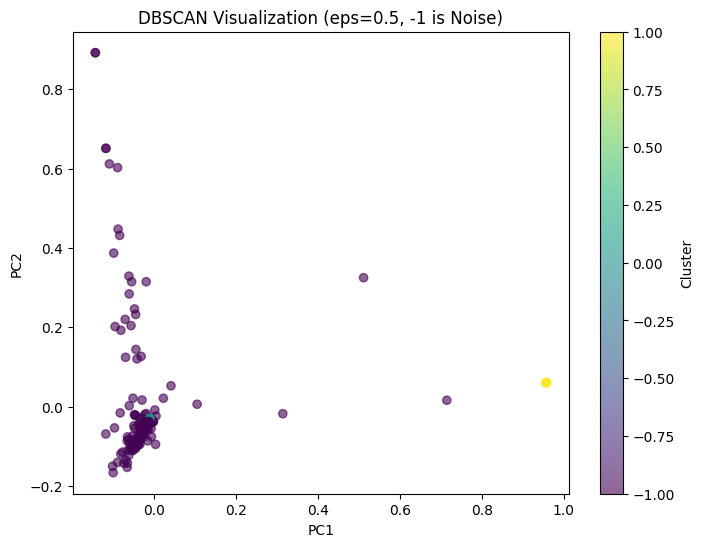

In [14]:
best_eps = 0.5

dbscan_final = DBSCAN(eps=best_eps, min_samples=5)
final_labels = dbscan_final.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=final_labels, cmap='viridis', alpha=0.6)
plt.title(f'DBSCAN Visualization (eps={best_eps}, -1 is Noise)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.show()


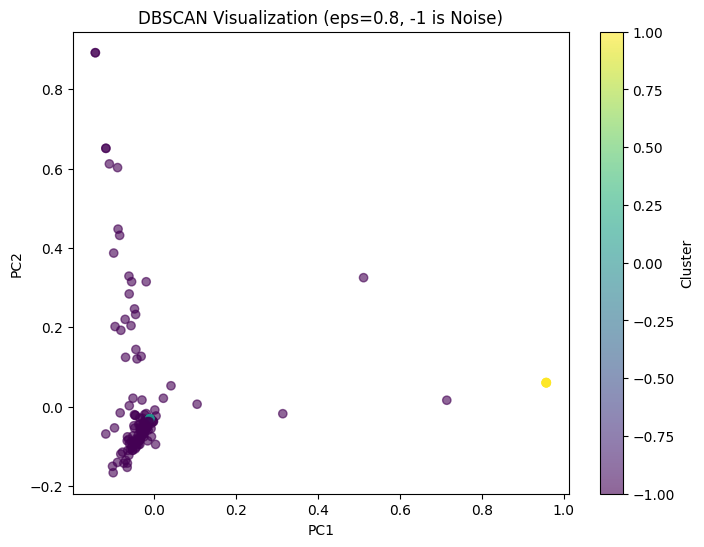

In [15]:
best_eps = 0.8

dbscan_final = DBSCAN(eps=best_eps, min_samples=5)
final_labels = dbscan_final.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=final_labels, cmap='viridis', alpha=0.6)
plt.title(f'DBSCAN Visualization (eps={best_eps}, -1 is Noise)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.show()


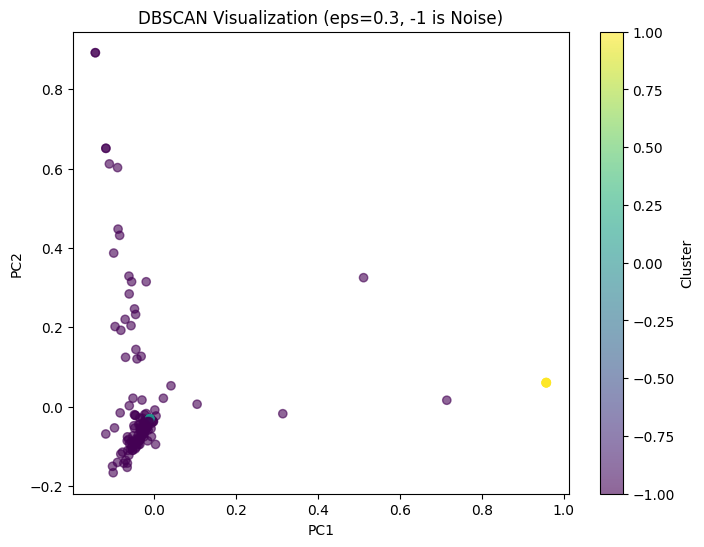

In [16]:
best_eps = 0.3

dbscan_final = DBSCAN(eps=best_eps, min_samples=5)
final_labels = dbscan_final.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=final_labels, cmap='viridis', alpha=0.6)
plt.title(f'DBSCAN Visualization (eps={best_eps}, -1 is Noise)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.show()


# **Try with different methods for better results and analysis**

## Step 1 — Data Validation and Hypothesis
- Load my dataset (`.csv` or `.txt`).
- Report its shape with `df.shape`.
- Based on my number of comments, what do my expect about cluster **quality**?  
  

In [17]:

!pip -q install pandas numpy matplotlib seaborn scikit-learn umap-learn kneed



import os, ast, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from textwrap import shorten
plt.rcParams['figure.dpi'] = 120


DATA_PATH = '/content/drive/MyDrive/CSE477/cleaned_comments.csv'

print("Using file:", DATA_PATH)
assert os.path.exists(DATA_PATH), "Path doesn't exist. Fix DATA_PATH above."


Using file: /content/drive/MyDrive/CSE477/cleaned_comments.csv


In [18]:

# Load dataset (CSV or TXT)
if DATA_PATH.lower().endswith(".csv"):
    df = pd.read_csv(DATA_PATH)
else:
    df = pd.read_table(DATA_PATH)

print(f"My dataset contains {df.shape[0]} comments and {df.shape[1]} columns.")
display(df.head())
print("Columns:", list(df.columns))


My dataset contains 200 comments and 4 columns.


,username,timestamp_text,comment_text,cleaned_tokens
0,@afzalhossen8454,Unknown,Subhan allah,"['subhan', 'allah']"
1,@AnimalPrimeHub,Unknown,15:05 My heart absolutely broke for that young...,"['heart', 'absolutely', 'broke', 'young', 'mot..."
2,@PreemKaSagar,Unknown,Hm ghaar maan thay blaak bicho nay kata hmin t...,"['ghaar', 'maan', 'thay', 'blaak', 'bicho', 'n..."
3,@Hasnainraza-fm7jp,Unknown,The two truths 🎉sound like sleep and good luck...,"['two', 'truth', 'sound', 'like', 'sleep', 'go..."
4,@Nimazz_z,Unknown,😊❤,[]


Columns: ['username', 'timestamp_text', 'comment_text', 'cleaned_tokens']


## Step 2 — Text → Vector (TF‑IDF)
Handles either `cleaned_tokens` (list/str of tokens) **or** `cleaned_text`.  
If neither is found, it tries to infer a text-like column automatically.

In [19]:

from sklearn.feature_extraction.text import TfidfVectorizer

def build_corpus(df):
    if 'cleaned_tokens' in df.columns:
        def to_tokens(x):
            if isinstance(x, list):
                return x
            if isinstance(x, str):
                # try to parse list-like strings, else fallback to split
                try:
                    v = ast.literal_eval(x)
                    if isinstance(v, list):
                        return [str(t) for t in v]
                except Exception:
                    pass
                return x.split()
            return []
        corpus = df['cleaned_tokens'].apply(to_tokens).apply(lambda toks: ' '.join(toks)).tolist()
        text_col = 'cleaned_tokens'
    elif 'cleaned_text' in df.columns:
        corpus = df['cleaned_text'].astype(str).tolist()
        text_col = 'cleaned_text'
    else:
        # Try to infer
        cand = None
        for c in df.columns:
            if df[c].dtype == object:
                avg_len = df[c].astype(str).str.len().mean()
                if avg_len > 10:
                    cand = c; break
        if cand is None:
            raise ValueError("No usable text column found. Expected 'cleaned_tokens' or 'cleaned_text'.")
        corpus = df[cand].astype(str).tolist()
        text_col = cand
    return corpus, text_col

corpus, text_col = build_corpus(df)
print("Using text column:", text_col)

# TF-IDF
vectorizer = TfidfVectorizer(
    max_features=4000,       # you can raise this if you have a lot of data
    ngram_range=(1, 2),      # unigrams + bigrams to catch short phrases
    min_df=2,                # ignore ultra-rare tokens
    token_pattern=r"(?u)\b\w+\b"
)
X = vectorizer.fit_transform(corpus)
terms = vectorizer.get_feature_names_out()

print("TF-IDF matrix shape:", X.shape)


Using text column: cleaned_tokens
TF-IDF matrix shape: (200, 276)


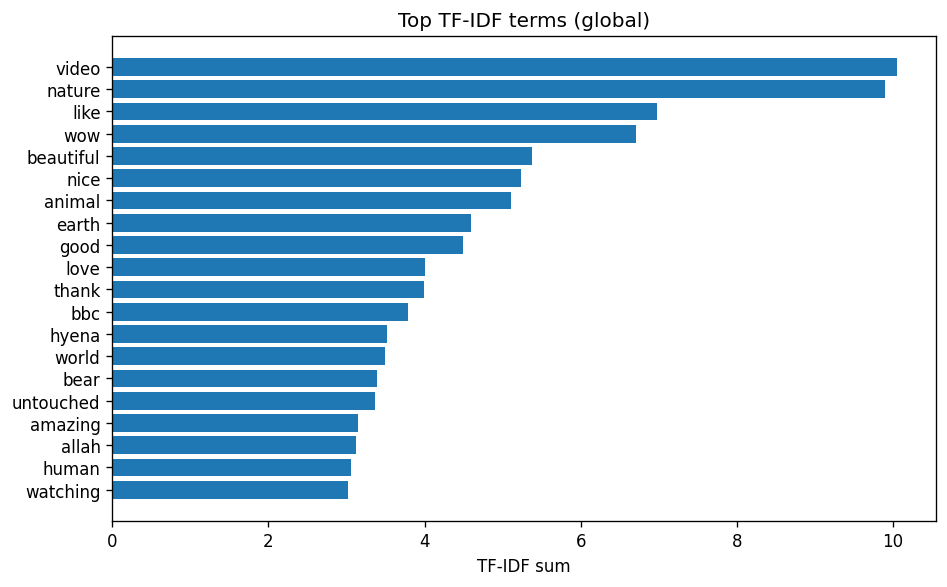

In [20]:

# Quick look: top TF-IDF terms globally
global_tfidf = np.asarray(X.sum(axis=0)).ravel()
topn = 20
top_idx = np.argsort(global_tfidf)[-topn:][::-1]

plt.figure(figsize=(8,5))
plt.barh(range(topn), global_tfidf[top_idx][::-1])
plt.yticks(range(topn), terms[top_idx][::-1])
plt.title("Top TF-IDF terms (global)")
plt.xlabel("TF-IDF sum")
plt.tight_layout()
plt.show()


## Step 3 — K-Means & Interpreting Results

### 3A. Elbow + Helpful Metrics
Besides inertia (elbow), we show:
- **Silhouette** (higher is better)
- **Calinski–Harabasz** (higher is better)
- **Davies–Bouldin** (lower is better)

This helps me when the elbow looks ambiguous.

In [22]:

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Reduce dimensionality for fast metrics (and later plots)
svd_dim = min(50, max(2, X.shape[1]-1))
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
X_svd = svd.fit_transform(X)

k_values = list(range(2, 9))
records, inertias = [], []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    try:
        sil = silhouette_score(X_svd, labels)
    except Exception:
        sil = float('nan')
    try:
        ch = calinski_harabasz_score(X_svd, labels)
    except Exception:
        ch = float('nan')
    try:
        db = davies_bouldin_score(X_svd, labels)
    except Exception:
        db = float('nan')
    records.append({
        'k': k,
        'inertia': km.inertia_,
        'silhouette (SVD)': sil,
        'calinski_harabasz (SVD)': ch,
        'davies_bouldin (SVD)': db,
    })

metrics_df = pd.DataFrame(records)
display(metrics_df.style.background_gradient(axis=0))




,k,inertia,silhouette (SVD),calinski_harabasz (SVD),davies_bouldin (SVD)
0,2,150.089363,0.199133,10.441302,1.067064
1,3,146.985020,0.121681,8.276469,2.739650
2,4,144.211747,0.084115,7.390208,1.655327
3,5,142.099068,0.133302,6.582851,1.243239
4,6,139.625409,0.114079,6.424243,2.869122
5,7,136.308338,0.190573,6.702123,1.145634
6,8,134.054979,0.159349,6.405714,1.259693


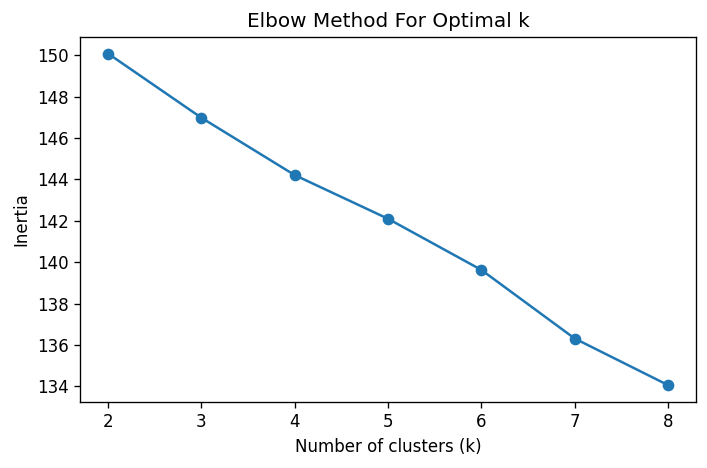

In [23]:
# Elbow plot
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.tight_layout()
plt.show()



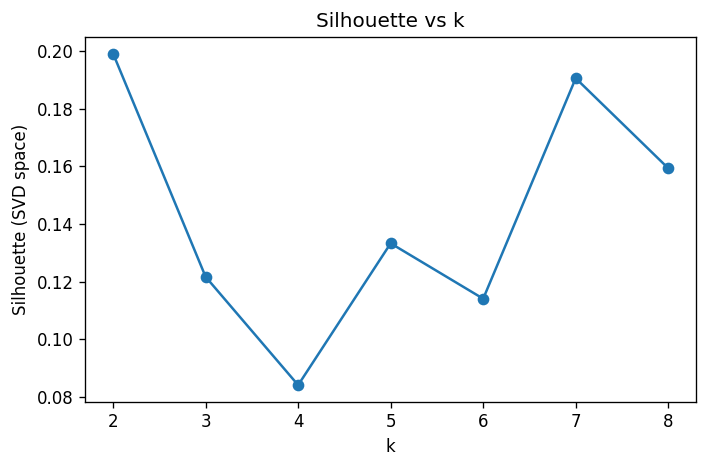

In [24]:
# Silhouette plot
plt.figure(figsize=(6,4))
plt.plot(k_values, metrics_df['silhouette (SVD)'], marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette (SVD space)')
plt.title('Silhouette vs k')
plt.tight_layout()
plt.show()



In [ ]:
# Try automatic knee detection (optional)
auto_k = None
try:
    from kneed import KneeLocator
    kl = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
    auto_k = kl.elbow
    print("Auto-selected k (elbow):", auto_k)
except Exception as e:
    print("KneeLocator not available/failed:", e)

# Choose k
optimal_k = int(auto_k) if auto_k is not None else 3
print("Using k =", optimal_k)

Cluster 0: nature(0.054), video(0.052), beautiful(0.032), nice(0.031), animal(0.030), love(0.024), earth(0.021), thank(0.021), hyena(0.021), world(0.021)


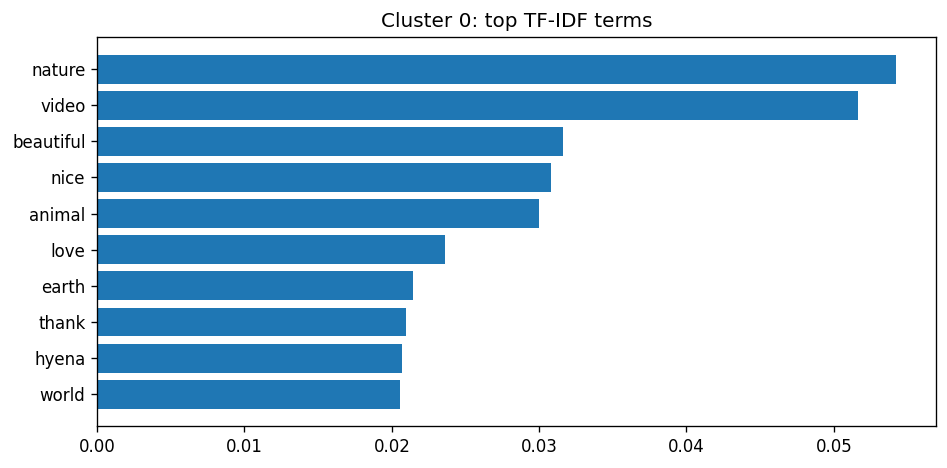

Cluster 1: like(0.314), thumbnail(0.077), moment(0.066), look(0.066), guest(0.056), really like(0.055), sound like(0.046), two(0.046), really(0.044), look like(0.044)


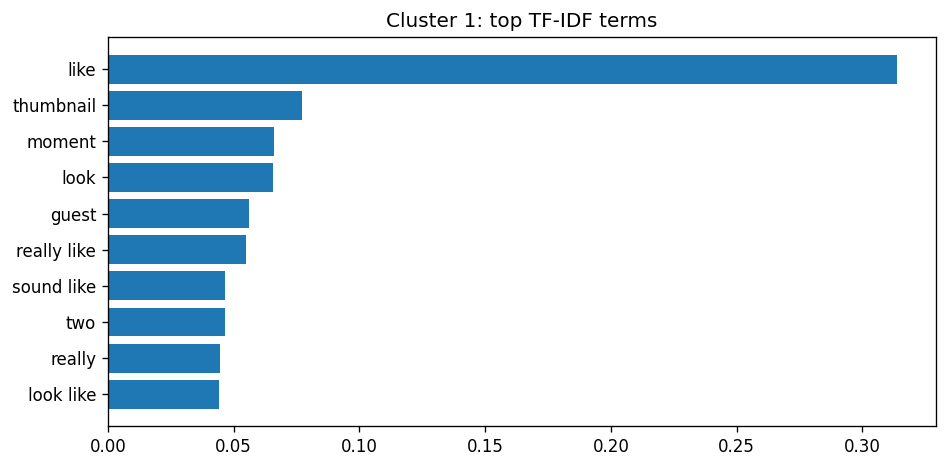

Cluster 2: wow(0.821), incredible(0.091), good(0.067), amazing(0.067), escaped(0.056), predator(0.053), thats(0.053), allah(0.051), video(0.049), really(0.048)


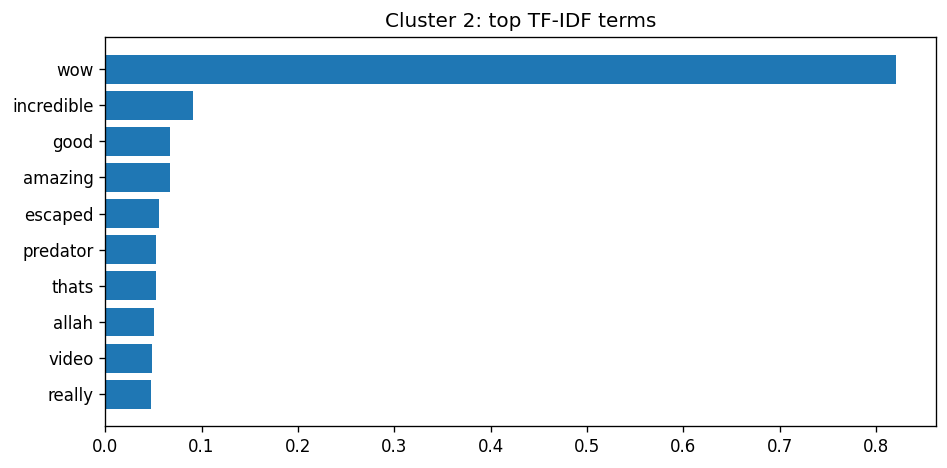

In [25]:

kmeans = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=10)
df['kmeans_label'] = kmeans.fit_predict(X)

# Top terms per cluster (printed + bar plot)
for i in range(int(optimal_k)):
    center = kmeans.cluster_centers_[i]
    top_idx = center.argsort()[-10:][::-1]
    print(f"Cluster {i}: " + ", ".join([f"{terms[j]}({center[j]:.3f})" for j in top_idx]))

    plt.figure(figsize=(8,4))
    plt.barh(range(10), center[top_idx][::-1])
    plt.yticks(range(10), terms[top_idx][::-1])
    plt.title(f"Cluster {i}: top TF-IDF terms")
    plt.tight_layout()
    plt.show()


### 3C. Visualize K-Means (2D)
I use **TruncatedSVD(2)** (works well for sparse TF‑IDF) to project to 2D.

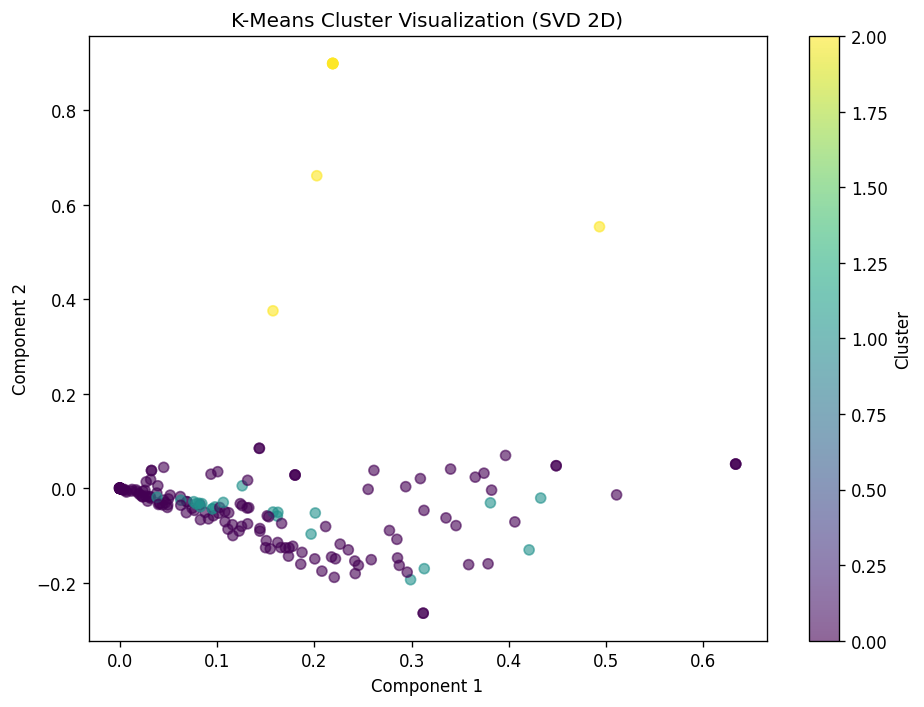


Cluster 0 sample comments:
- ['incredible', 'footage', 'nature', 'bomb', 'matter', 'location', 'impala', 'escaped', 'smoothly']
- ['heartbreaking', 'see', 'planet', 'forest', 'wildlife', 'struggling', 'year', 'harsher', 'climate', 'weve', 'got', 'act', 'fast', 'protect', 'wonder', 'world', 'environmental', 'decline', [...]
- ['calming', 'yet', 'wild', 'time', 'recently', 'posted', 'amazing', 'animal', 'battlesnature', 'fascinating']

Cluster 1 sample comments:
- ['pcb', 'student', 'like', 'seriously', 'completed', 'chapter', 'ecology', 'watching']
- ['bro', 'like', 'spill', 'goo', 'yabadabadoooo']
- ['bear', 'cute', 'really', 'like']

Cluster 2 sample comments:
- ['wow', 'incredible']
- ['wow']
- ['wow']


In [26]:

svd2 = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd2.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=df['kmeans_label'], alpha=0.6)
plt.title('K-Means Cluster Visualization (SVD 2D)')
plt.xlabel('Component 1'); plt.ylabel('Component 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Show 3 representative comments closest to each cluster center (in 2D)
import numpy as np
examples = {}
for i in range(int(optimal_k)):
    idxs = np.where(df['kmeans_label'].values==i)[0]
    if len(idxs)==0:
        continue
    centroid = X_2d[idxs].mean(axis=0)
    dists = np.linalg.norm(X_2d[idxs] - centroid, axis=1)
    top = idxs[np.argsort(dists)[:3]]
    print(f"\nCluster {i} sample comments:")
    for t in df.iloc[top][text_col].tolist():
        print("-", shorten(str(t).replace("\n"," "), width=200))


## Step 4 — DBSCAN (Comparative Analysis)

Key ideas:
- `eps`: neighborhood radius  
- `min_samples`: minimum points to form a cluster (start with 5)

I **scale** the sparse TF‑IDF with `StandardScaler(with_mean=False)` and try multiple `eps` values.

In [27]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Scale sparse matrix directly
X_scaled = StandardScaler(with_mean=False).fit_transform(X)

eps_candidates = [0.3, 0.5, 0.7, 0.9, 1.2]
results = []
labels_map = {}

for eps in eps_candidates:
    dbscan = DBSCAN(eps=eps, min_samples=5, n_jobs=-1)
    labels = dbscan.fit_predict(X_scaled)
    labels_map[eps] = labels

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = int((labels == -1).sum())

    # silhouette only if at least 2 clusters
    try:
        from sklearn.metrics import silhouette_score
        sil = silhouette_score(X_svd, labels) if n_clusters > 1 else float('nan')
    except Exception:
        sil = float('nan')

    results.append({'eps': eps, 'min_samples': 5, 'clusters': n_clusters, 'noise_points': n_noise, 'silhouette (SVD)': sil})

res_df = pd.DataFrame(results)
display(res_df.style.background_gradient(axis=0))

# Choose best eps by silhouette (fallback to 0.5 if all NaN)
if res_df['silhouette (SVD)'].notna().any():
    best_eps = float(res_df.sort_values(['silhouette (SVD)'], ascending=False).iloc[0]['eps'])
else:
    best_eps = 0.5

print("Chosen eps:", best_eps)
dbscan_final = DBSCAN(eps=best_eps, min_samples=5, n_jobs=-1)
final_labels = dbscan_final.fit_predict(X_scaled)
df['dbscan_label'] = final_labels


,eps,min_samples,clusters,noise_points,silhouette (SVD)
0,0.300000,5,2,155,0.006019
1,0.500000,5,2,155,0.006019
2,0.700000,5,2,155,0.006019
3,0.900000,5,2,155,0.006019
4,1.200000,5,2,155,0.006019


Chosen eps: 0.3


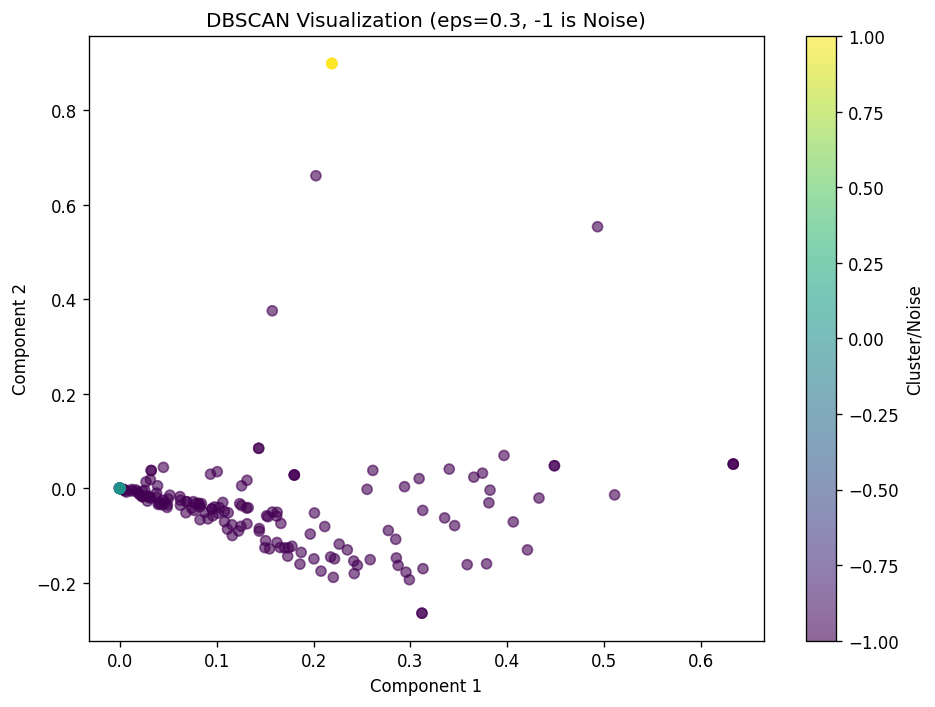

K-Means cluster counts: {np.int32(0): np.int64(170), np.int32(1): np.int64(22), np.int32(2): np.int64(8)}
DBSCAN cluster/noise counts: {np.int64(-1): np.int64(155), np.int64(0): np.int64(40), np.int64(1): np.int64(5)}


In [28]:

# Visualize DBSCAN on the same 2D projection (X_2d)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=df['dbscan_label'], alpha=0.6)
plt.title(f'DBSCAN Visualization (eps={best_eps}, -1 is Noise)')
plt.xlabel('Component 1'); plt.ylabel('Component 2')
plt.colorbar(scatter, label='Cluster/Noise')
plt.tight_layout()
plt.show()

def counts(d):
    u, c = np.unique(d, return_counts=True)
    return dict(zip(u, c))

print("K-Means cluster counts:", counts(df['kmeans_label'].values))
print("DBSCAN cluster/noise counts:", counts(df['dbscan_label'].values))


In [30]:

# Export labeled data
keep_cols = [text_col] + [c for c in ['kmeans_label','dbscan_label'] if c in df.columns]
out_path = '/content/drive/MyDrive/CSE477/CSE477_lab5_clustered_comments.csv'
df[keep_cols].to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: /content/drive/MyDrive/CSE477/CSE477_lab5_clustered_comments.csv


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


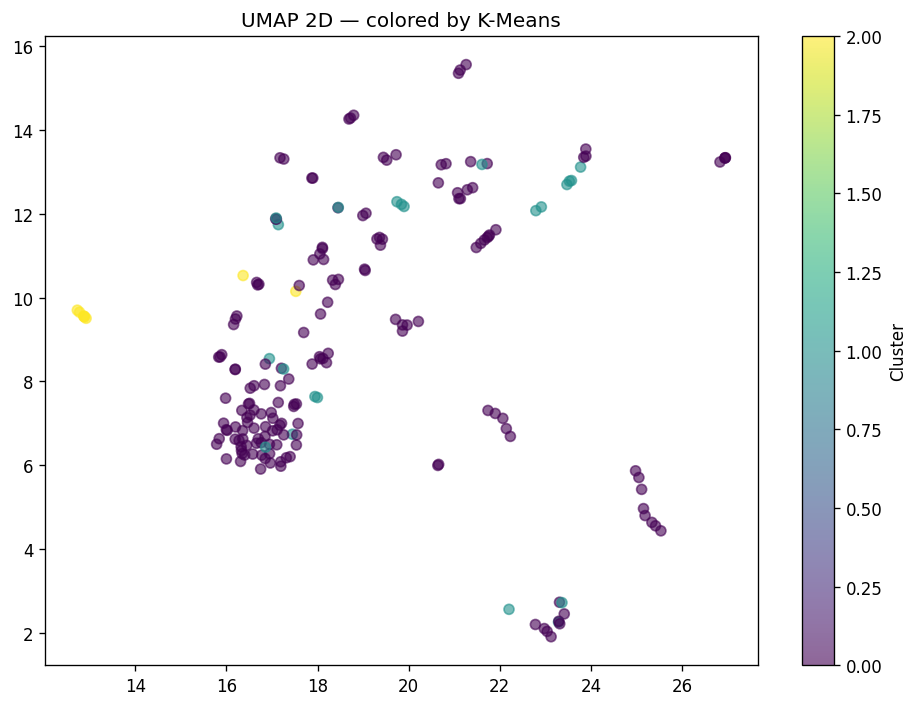

In [31]:

try:
    import umap
    umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X_svd)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(umap_2d[:,0], umap_2d[:,1], c=df['kmeans_label'], alpha=0.6)
    plt.title('UMAP 2D — colored by K-Means')
    plt.colorbar(sc, label='Cluster')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("UMAP not available:", e)
